![image.png](attachment:image.png)

This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images. 

## Preparation of the data

Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We display the files in Kaggle repertoire :

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

We create the variable X containing all the images of cars by resizing them.



In [3]:
IMAGE_SIZE = 224

In [4]:
img_dir = "/content/drive/MyDrive/ICT720_Software/Project/archive/images/" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [5]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [6]:
path = '/content/drive/MyDrive/ICT720_Software/Project/archive/annotations/'
text_files = ['/content/drive/MyDrive/ICT720_Software/Project/archive/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [7]:
resizeannotation("/content/drive/MyDrive/ICT720_Software/Project/archive/annotations/Cars147.xml")

[188, 141, 101, 104]

In [8]:
y[0]

[187, 144, 101, 104]

We check X et y shape

In [9]:
np.array(X).shape

(433, 224, 224, 3)

In [10]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset : 

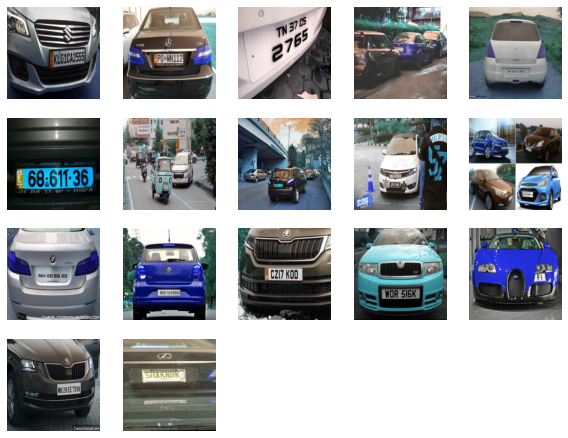

In [11]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

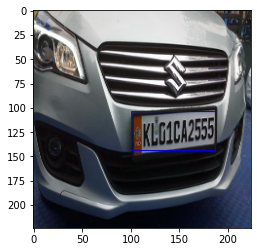

In [12]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


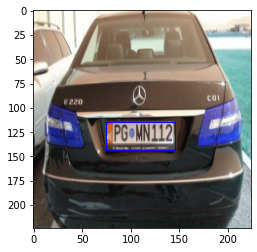

In [13]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [14]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [15]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [17]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [18]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [19]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [21]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
10/10 [==============================] - 237s 24s/step - loss: 0.0566 - accuracy: 0.4855 - val_loss: 0.0246 - val_accuracy: 0.6000
Epoch 2/50
10/10 [==============================] - 236s 24s/step - loss: 0.0167 - accuracy: 0.6174 - val_loss: 0.0181 - val_accuracy: 0.6000
Epoch 3/50
10/10 [==============================] - 236s 24s/step - loss: 0.0078 - accuracy: 0.8071 - val_loss: 0.0166 - val_accuracy: 0.7143
Epoch 4/50
10/10 [==============================] - 237s 24s/step - loss: 0.0044 - accuracy: 0.8682 - val_loss: 0.0151 - val_accuracy: 0.6000
Epoch 5/50
10/10 [==============================] - 235s 24s/step - loss: 0.0025 - accuracy: 0.8810 - val_loss: 0.0146 - val_accuracy: 0.7429
Epoch 6/50
10/10 [==============================] - 235s 24s/step - loss: 0.0017 - accuracy: 0.9100 - val_loss: 0.0149 - val_accuracy: 0.8000
Epoch 7/50
10/10 [==============================] - 239s 24s/step - loss: 0.0014 - accuracy: 0.9357 - val_loss: 0.0147 - val_accuracy: 0.8000
Epoch 

In [23]:
model.save('my_model.h5', overwrite=True) 

In [20]:
model.load_weights("/content/drive/MyDrive/ICT720_Software/Project/my_model.h5")

In [21]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 87.36%


In [22]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [23]:
plot_scores(train)

NameError: ignored

## DETECTION 

In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


 87/100 [=========================>....] - ETA: 8s - loss: 0.0065 - accuracy: 0.8736

100/100 [==============================] - 59s 589ms/step - loss: 0.0065 - accuracy: 0.8736
Test results 
 Loss: 0.006476803217083216 
 Accuracy 0.8735632300376892


In [43]:
import tensorflow as tf

# load image via tf.io
img = tf.io.read_file("/content/drive/MyDrive/ICT720_Software/sample_data/Sample_data4.jpeg")

# convert to tensor (specify 3 channels explicitly since png files contains additional alpha channel)
# set the dtypes to align with pytorch for comparison since it will use uint8 by default
tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
# (384, 470, 3)

# resize tensor to 224 x 224
tensor = tf.image.resize(tensor, [224, 224])
# (224, 224, 3)

# add another dimension at the front to get NHWC shape
input_tensor = tf.expand_dims(tensor, axis=0)
# (1, 224, 224, 3)

In [44]:
y_cnn = model.predict(input_tensor)

1/1 [==============================] - 1s 572ms/step


We can see how our model localize license plates on our testing set :

In [45]:
love = np.array(input_tensor)

IndexError: ignored

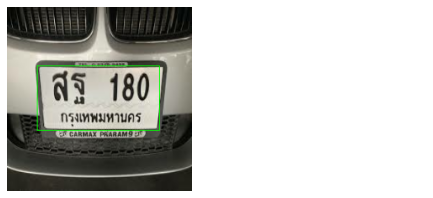

In [46]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(love[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)